# Plots on a native (non-regridded) mesh

In [1]:
import warnings

warnings.filterwarnings("ignore")

from functools import partial
from pathlib import Path
from typing import NamedTuple

import cartopy.crs as ccrs
import cmcrameri
import cmocean
import geovista as gv
import iris
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import numpy as np
import pyvista as pv
import swiftascmaps
from aeolus.calc import last_n_day_mean, precip_sum, time_mean
from aeolus.const import init_const
from aeolus.coord import DimCoord, isel
from aeolus.lfric import (
    add_um_height_coord,
    fix_time_coord,
    load_lfric_raw,
    ugrid_spatial,
    ugrid_spatial_mean,
)
from aeolus.model import lfric
from aeolus.plot import (
    capitalise,
    make_list_2d,
    map_scatter,
    subplot_label_generator,
    tex2cf_units,
    timeseries_1d,
    timeseries_2d,
    unit_format,
)
from aeolus.plot.pv import cube2d_to_mesh, ugrid_mesh_to_gv_mesh
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from tqdm.notebook import tqdm

pv.global_theme.trame.server_proxy_enabled = True
pv.set_jupyter_backend("trame")

import paths
from common import DAYSIDE, NIGHTSIDE, SIMULATIONS

In [2]:
from iris.cube import Cube
from iris.experimental.ugrid import MeshCoord
from iris.experimental.ugrid.mesh import Mesh


def replace_mesh(cube: Cube, new_mesh: Mesh) -> Cube:
    """Replace mesh in a 1d cube by creating a new copy of that cube."""
    mesh_x = MeshCoord(mesh=new_mesh, location="face", axis="x")
    mesh_y = MeshCoord(mesh=new_mesh, location="face", axis="y")

    new_cube = Cube(cube.data, aux_coords_and_dims=[(mesh_x, 0), (mesh_y, 0)])
    new_cube.metadata = cube.metadata
    return new_cube

In [3]:
plt.style.use("custom.mplstyle")

In [6]:
show_sim = ["c192s10e", "c192p"]
time_prof = "inst_diag"
# time_prof = "averages"
const = init_const("hab1", directory=paths.const)

## Load the data

In [ ]:
dset = {}
for sim_label in show_sim:
    dset[sim_label] = {}
    add_levs = partial(
        add_um_height_coord,
        path_to_levels_file=paths.vert / SIMULATIONS[sim_label].vert_lev,
    )

    def combi_callback(cube, field, filename):
        [
            fix_time_coord(cube, field, filename),
            add_levs(cube, field, filename),
        ]

    fnames = sorted(
        paths.data_raw.glob(
            str(
                Path(SIMULATIONS[sim_label].work_name)
                / "*"
                / "run_lfric_atm_*"
                / f"lfric_{time_prof}.nc"
            )
        ),
        key=lambda x: int(x.parent.parent.name),
    )[-50:]

    dset[sim_label][time_prof] = load_lfric_raw(
        fnames,
        callback=combi_callback,
        drop_coord=["forecast_reference_time"],
    )

    # Load cell area
    cell_area = load_lfric_raw(
        paths.data_raw
        / SIMULATIONS[sim_label].work_name
        / "1"
        / "run_lfric_atm_*"
        / "lfric_initial.nc",
    ).extract_cube("cell_area")
    # Replace the mesh in the cell area cube to be compatible with main data cubes
    cell_area = replace_mesh(
        cell_area, dset[sim_label][time_prof][0].mesh
    )
    dset[sim_label][time_prof].append(cell_area)
    del cell_area

In [8]:
for i, cube in enumerate(dset["c192p"][time_prof]):
    print(f"---|---|-{'-'*30}-|-{'-'*60}")
    print(f"{i:<2d} | {cube.ndim} | {cube.var_name:>30} | {cube.name():>60}")

---|---|--------------------------------|-------------------------------------------------------------
0  | 2 |      tot_col_uv_kinetic_energy |                 atmosphere_horizontal_kinetic_energy_content
---|---|--------------------------------|-------------------------------------------------------------
1  | 2 |       tot_col_w_kinetic_energy |                   atmosphere_vertical_kinetic_energy_content
---|---|--------------------------------|-------------------------------------------------------------
2  | 2 |            cloud_amount_maxrnd |                                          cloud_area_fraction
---|---|--------------------------------|-------------------------------------------------------------
3  | 2 |       grid_surface_temperature |                                     grid_surface_temperature
---|---|--------------------------------|-------------------------------------------------------------
4  | 2 |          low_type_cloud_amount |                                

## Global diagnostics

Fig. 4 in Kajikawa16_resolution

In [10]:
recipe_mean = lambda cube, weights: time_mean(
    ugrid_spatial(cube, "mean", weights=weights, model=lfric), model=lfric
)
recipe_std = lambda cube: time_mean(
    ugrid_spatial(cube, "std_dev", model=lfric), model=lfric
)
recipe_min = lambda cube: time_mean(
    ugrid_spatial(cube, "min", model=lfric), model=lfric
)
recipe_max = lambda cube: time_mean(
    ugrid_spatial(cube, "max", model=lfric), model=lfric
)

In [11]:
Diag = NamedTuple(
    "Diag",
    [
        ("recipe", callable),
        ("title", str),
        ("units", str),
        ("lim", tuple),
        ("scale", str),
        ("unit_format_kwargs", dict),
    ],
)

In [95]:
DIAGS = {
    "t_sfc": Diag(
        recipe=lambda cl: cl.extract_cube(lfric.t_sfc),
        title="Surface Temperature",
        units="K",
        lim=[175, 300],
        scale="linear",
        unit_format_kwargs=dict(exponent=1),
    ),
    "toa_olr": Diag(
        recipe=lambda cl: cl.extract_cube(lfric.toa_olr),
        title="TOA OLR",
        units="$W$ $m^{-2}$",
        lim=[50, 300],
        scale="linear",
        unit_format_kwargs=dict(exponent=1),
    ),
    "caf": Diag(
        recipe=lambda cl: cl.extract_cube(lfric.caf),
        title="Cloud Fraction",
        units="%",
        lim=[0, 100],
        scale="linear",
        unit_format_kwargs=dict(exponent=1),
    ),
    "tot_col_uv_kinetic_energy": Diag(
        recipe=lambda cl: cl.extract_cube("tot_col_uv_kinetic_energy"),
        title="Total Column Horizontal\nKinetic Energy",
        units="$J$ $m^{-2}$",
        lim=[1e5, 1e8],
        scale="log",
        unit_format_kwargs=dict(),
    ),
    "tot_col_w_kinetic_energy": Diag(
        recipe=lambda cl: cl.extract_cube("tot_col_w_kinetic_energy"),
        title="Total Column Vertical\nKinetic Energy",
        units="$J$ $m^{-2}$",
        lim=[1e-3, 1e6],
        scale="log",
        unit_format_kwargs=dict(),
    ),
    "ls_prec": Diag(
        recipe=lambda cl: cl.extract_cube("ls_prec") / const.condensible_density,
        title="Large-scale Precipitation rate",
        units="$mm$ $h^{-1}$",
        lim=[0, 10],
        scale="linear",
        unit_format_kwargs=dict(),
    ),
}

In [23]:
diag_keys = ["t_sfc", "toa_olr", "tot_col_uv_kinetic_energy", "tot_col_w_kinetic_energy"]

In [84]:
constrain_spatially = lambda cube: cube
# constrain_spatially = lambda cube: cube.extract(DAYSIDE.constraint)

In [85]:
diag_computed = {}
for sim_label in show_sim:
    diag_computed[sim_label] = {}
    for diag_key in diag_keys:
        cube = DIAGS[diag_key].recipe(dset[sim_label][time_prof])
        cube.convert_units(tex2cf_units(DIAGS[diag_key].units))
        cube = constrain_spatially(cube)
        cube_mean = recipe_mean(
            cube,
            weights=constrain_spatially(
                dset[sim_label][time_prof].extract_cube("cell_area")
            ).lazy_data(),
        )
        diag_computed[sim_label][diag_key] = {
            "mean": float(cube_mean.data),
            "std": float(recipe_std(cube).data),
            "min": float(recipe_min(cube).data),
            "max": float(recipe_max(cube).data),
        }

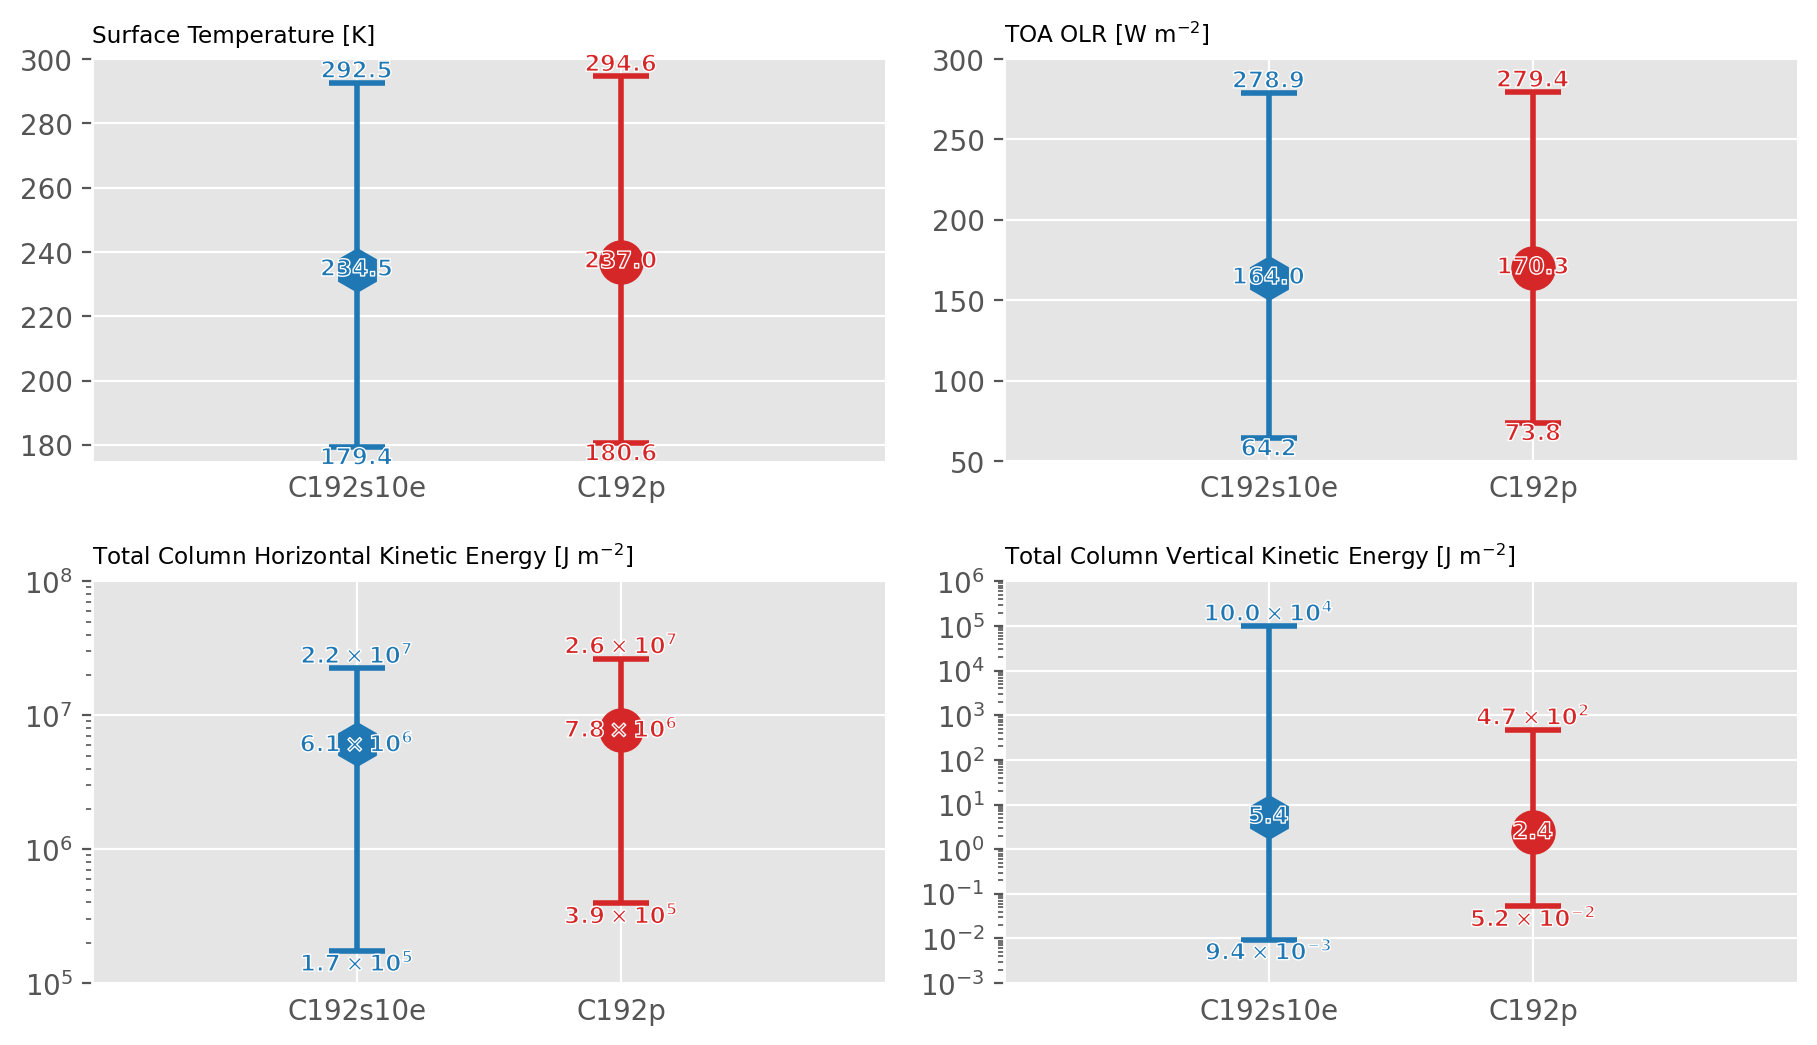

In [96]:
with plt.style.context("ggplot"):
    fig = plt.figure(figsize=(11, 6))
    axd = fig.subplot_mosaic(
        [diag_keys[: len(diag_keys) // 2], diag_keys[len(diag_keys) // 2 :]],
        gridspec_kw={"wspace": 0.15, "hspace": 0.3},
    )
    kw_text = dict(
        ha="center",
        weight="bold",
        size="small",
        path_effects=[path_effects.Stroke(linewidth=0.5, foreground="w")], # #555555
    )
    for diag_key in diag_keys:
        ax = axd[diag_key]
        for isim, sim_label in enumerate(show_sim):
            value_mean = diag_computed[sim_label][diag_key]["mean"]
            value_min = diag_computed[sim_label][diag_key]["min"]
            value_max = diag_computed[sim_label][diag_key]["max"]
            yerr = [[abs(value_min - value_mean)], [abs(value_max - value_mean)]]
            ax.errorbar(
                isim,
                value_mean,
                yerr=yerr,
                fmt=SIMULATIONS[sim_label].kw_plt["marker"],
                capsize=10,
                capthick=2,
                markersize=15,
                color=SIMULATIONS[sim_label].kw_plt["color"],
                elinewidth=2,
            )
            kw_text.update(color=SIMULATIONS[sim_label].kw_plt["color"])
            try:
                ax.text(
                    isim,
                    value_mean,
                    unit_format(value_mean, **DIAGS[diag_key].unit_format_kwargs),
                    va="center",
                    **kw_text,
                )
                if value_max != 100:
                    ax.text(
                        isim,
                        value_max,
                        unit_format(value_max, **DIAGS[diag_key].unit_format_kwargs),
                        va="bottom",
                        **kw_text,
                    )
                if value_min != 0:
                    ax.text(
                        isim,
                        value_min,
                        unit_format(value_min, **DIAGS[diag_key].unit_format_kwargs),
                        va="top",
                        **kw_text,
                    )
            except:
                pass
        ax.set_xlim(-1, len(show_sim))
        ax.set_xticks(range(len(show_sim)))
        ax.set_xticklabels([SIMULATIONS[sim_label].title for sim_label in show_sim])
        ax.set_yscale(DIAGS[diag_key].scale)
        ylabel = f"{DIAGS[diag_key].title}"
        if (tex_units := DIAGS[diag_key].units) != "1":
            ylabel += f" [{tex_units}]"
        ylabel = ylabel.replace("\n", " ")
        ax.set_title(ylabel, loc="left", size="small")

        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines.bottom.set_visible(False)
        ax.set_ylim(DIAGS[diag_key].lim)
        ax.spines.left.set_bounds(DIAGS[diag_key].lim)
        ax.tick_params(axis="x", which="both", length=0, pad=5)

Fig. 7 in Kajikawa16_resolution

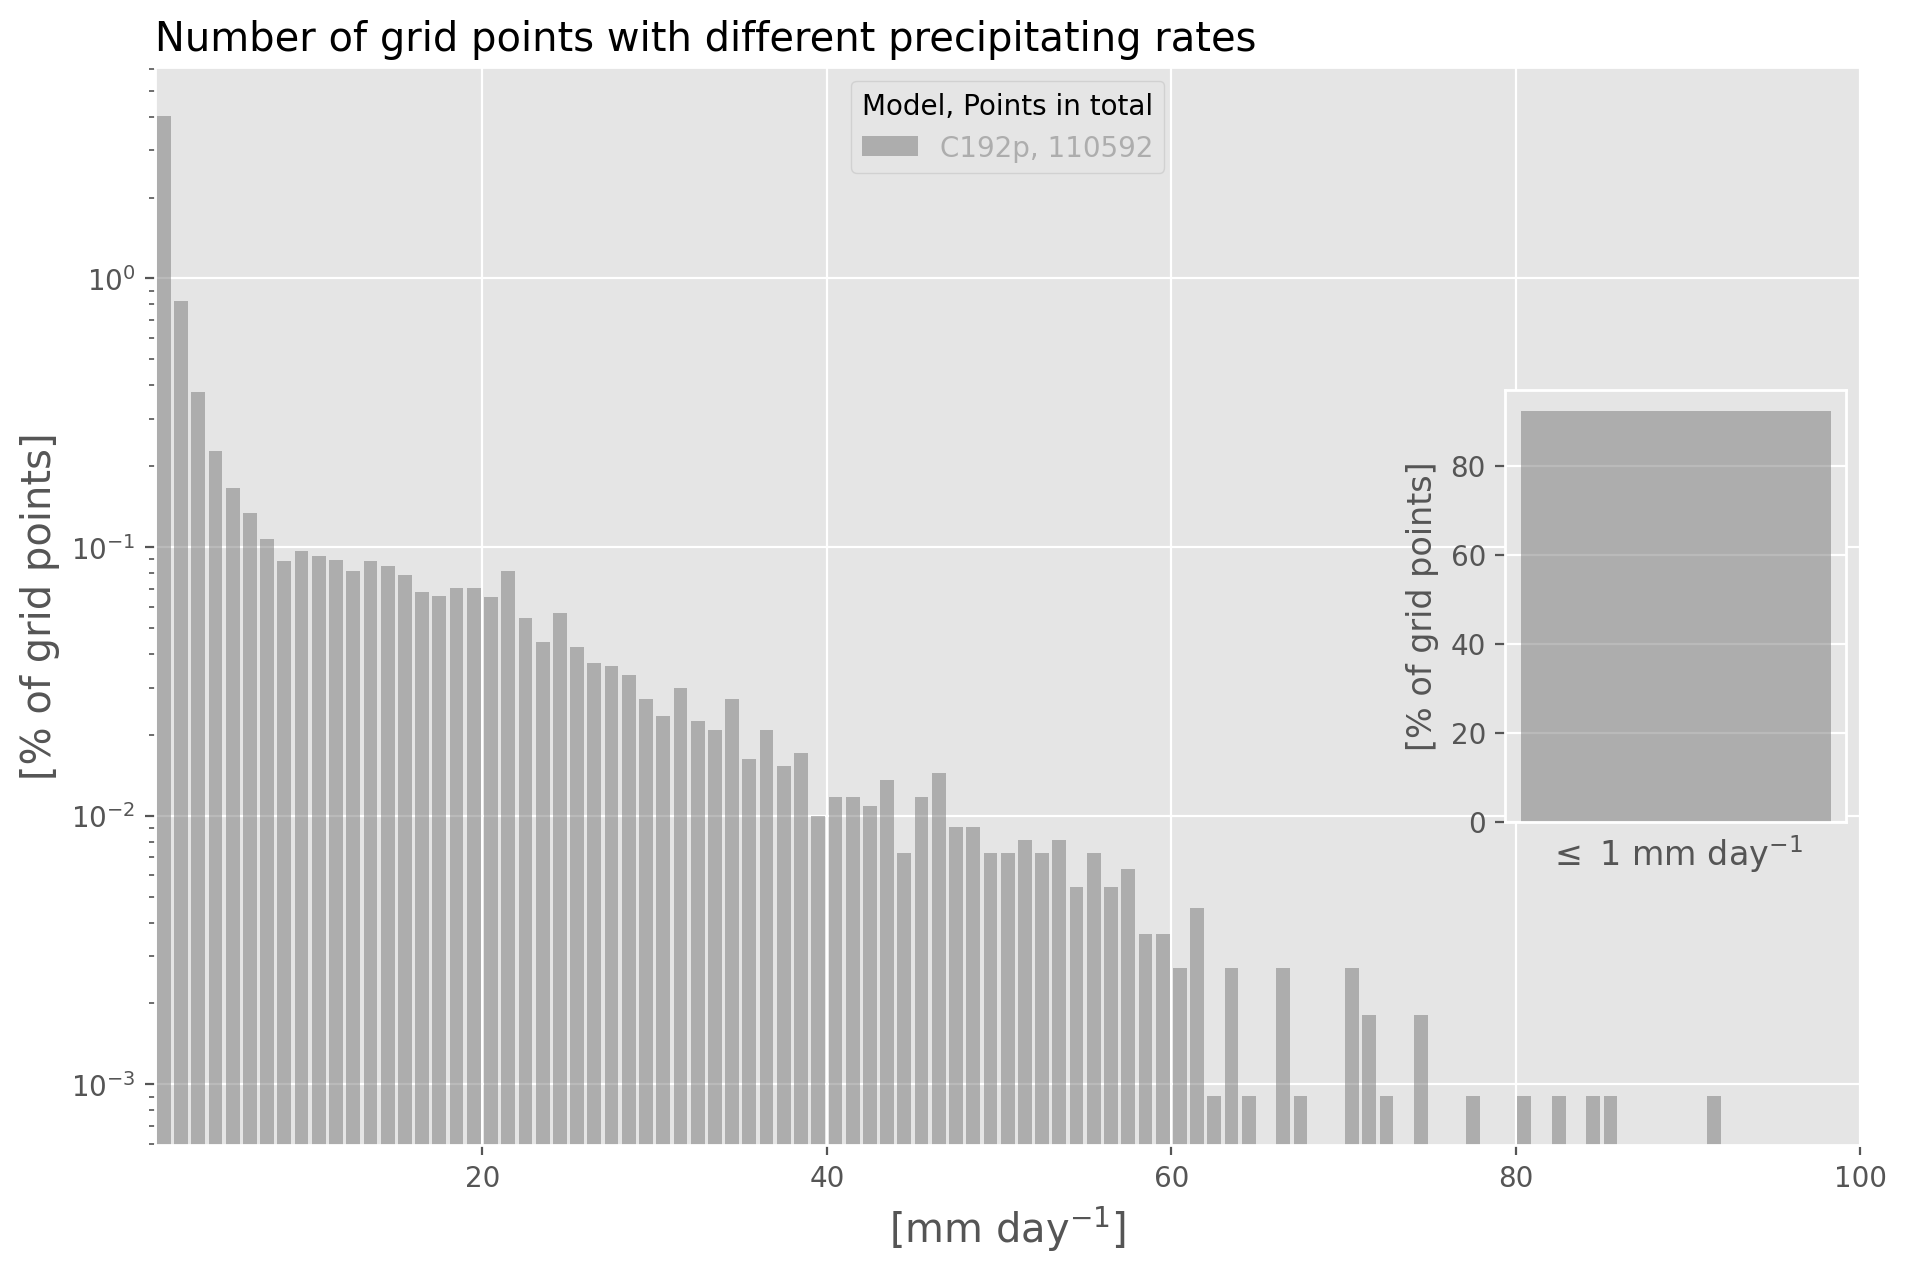

In [93]:
bins = np.arange(1, 101, 1)
bin_mid = (bins[:-1] + bins[1:]) * 0.5

with plt.style.context("ggplot"):
    fig, ax = plt.subplots(figsize=(11, 6))
    axins = inset_axes(ax, width="20%", height="40%", loc=5)
    
    tex_units = "$mm$ $day^{-1}$"
    
    for i, sim_label in enumerate(["c192p"]):
        cube = isel(
            dset[sim_label][time_prof]
            .extract_cube("ls_prec")
            .extract(DAYSIDE.constraint), lfric.t, -1
        )
        cube /= const.condensible_density
        cube.convert_units(tex2cf_units(tex_units))
        cube_data = cube.data.flatten()
        tot_pnts = cube_data.size
        label = f"{SIMULATIONS[sim_label].title}, {tot_pnts}"
        inc_points = cube_data[cube_data > 1]
        #     inc_points = np.clip(inc_points, bins[0], bins[-1])
        hist, _ = np.histogram(inc_points, bins=bins)
        color = SIMULATIONS[sim_label].kw_plt["color"]
        ax.bar(bin_mid, hist / tot_pnts * 100, label=label, alpha=0.5, color=color)
        # Number of non-precip points in an inset axis
        non_precip_size = cube_data[cube_data <= 1].size
        axins.bar(i, non_precip_size / tot_pnts * 100, alpha=0.5, color=color)
    
    axins.set_ylabel("[% of grid points]")
    axins.set_xticks([])
    axins.set_xlabel(f"$\leq$ 1 {tex_units}")
    
    leg = ax.legend(loc="upper center")
    leg.set_title("Model, Points in total")
    
    ax.set_yscale("log")
    # ax.set_xscale("log")
    ax.set_xlim(bins[0], bins[-1])
    # ax.set_xticks(np.concatenate([[bins[0]], bins[19::20]]))
    # ax.set_ylabel(f'[% of precipitating grid points ($\gt$ 1 {unit_str})]')
    ax.set_ylabel("[% of grid points]", size="x-large")
    ax.set_xlabel(f"[{tex_units}]", size="x-large")
    ax.set_title("Number of grid points with different precipitating rates", loc="left");

In [10]:
from scipy import stats
import pandas as pd

In [11]:
cube = isel(
    dset[sim_label][time_prof].extract_cube("total_prec").extract(DAYSIDE.constraint),
    lfric.t,
    -1,
)
cube /= const.condensible_density
cube.convert_units(tex2cf_units(tex_units))
cube_data = cube.data.flatten()

(1e-06, 1.0)

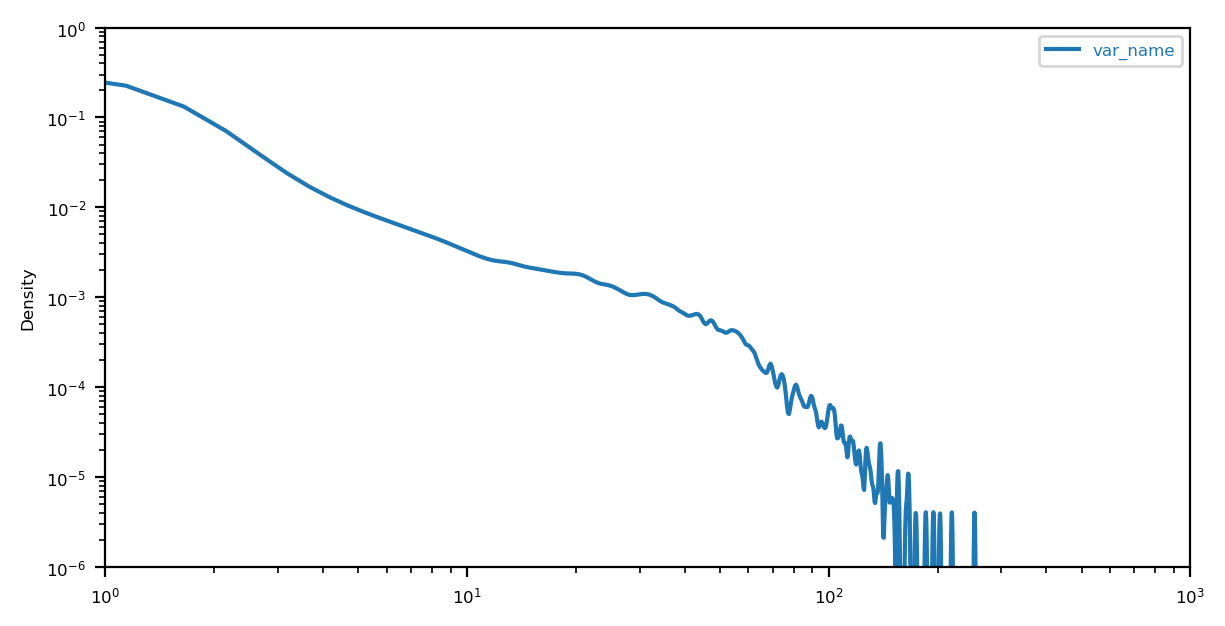

In [12]:
df = pd.DataFrame(cube_data, columns=["var_name"])  # Converting array to pandas DataFrame
ax = plt.axes()
df.plot(kind="density", ax=ax)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(1e0, 1e3)
ax.set_ylim(1e-6, 1e0)

(1e-06, 1.0)

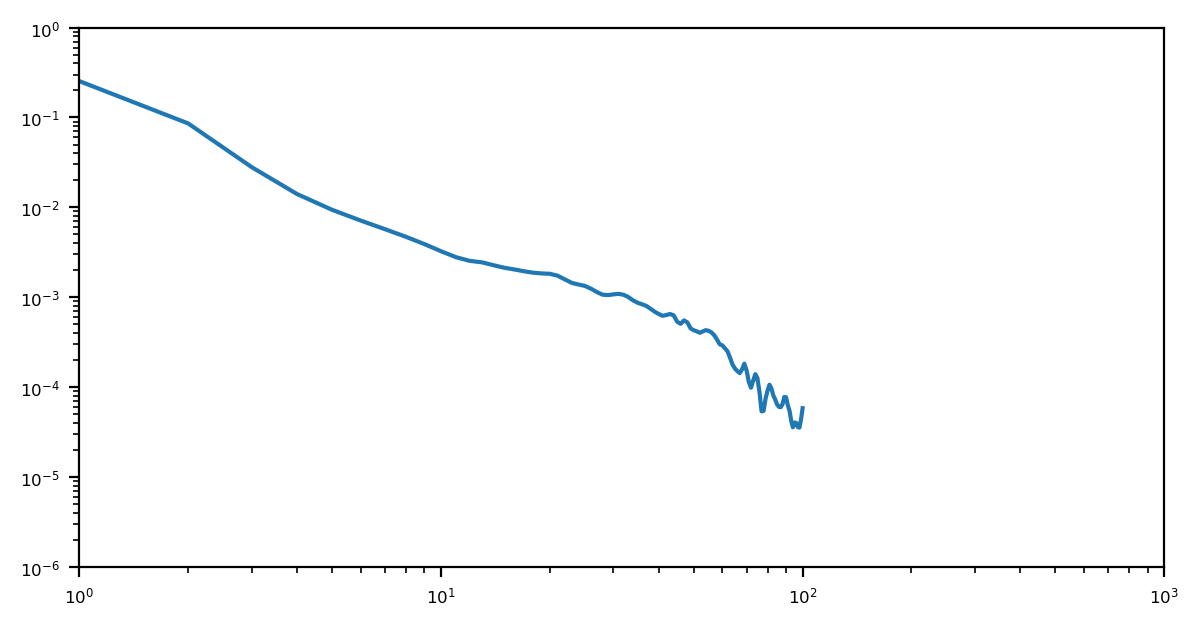

In [13]:
density = stats.gaussian_kde(cube_data)
# density.covariance_factor = lambda : 0.5
density._compute_covariance()

ax = plt.axes()
ax.plot(bins, density(bins))
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(1e0, 1e3)
ax.set_ylim(1e-6, 1e0)

/home/ds591/miniforge3/envs/plot3d/lib/python3.12/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'mesh_coordinates', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'mesh_coordinates'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/home/ds591/miniforge3/envs/plot3d/lib/python3.12/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'mesh_coordinates', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'mesh_coordinates'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))


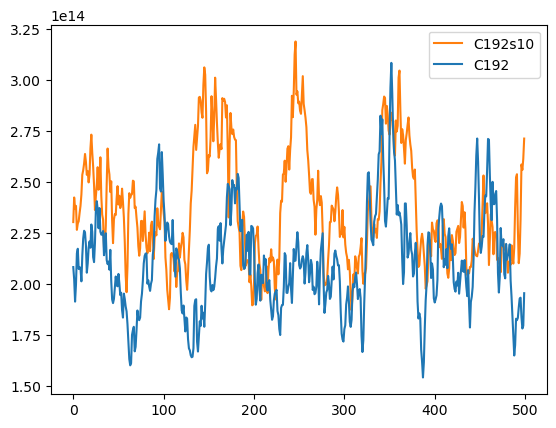

In [6]:
ax = plt.axes()
for sim_label in show_sim:
    cube = dset[sim_label][time_prof].extract_cube("low_type_cloud_amount")
    cube_sum = ugrid_spatial(
        cube, "sum", model=lfric, weights=dset[sim_label]["cell_area"].lazy_data()
    )
    timeseries_1d(
        cube_sum,
        ax=ax,
        **SIMULATIONS[sim_label].kw_plt,
        label=SIMULATIONS[sim_label].title
    )
ax.legend();

Fig. 6 in Kajikawa16_resolution

In [7]:
cloud_types = ["very_low", "low", "medium", "high", "very_high"]

# calculate the metrics first
area_factor = 1e14
metrics = {}
for sim_label in show_sim:
    metrics[sim_label] = {}
    for cloud_type in cloud_types:
        metrics[sim_label][cloud_type] = time_mean(
            ugrid_spatial(
                dset[sim_label][time_prof]
                .extract_cube(f"{cloud_type}_type_cloud_amount")
                .extract(DAYSIDE.constraint),
                "mean",
                model=lfric,
                weights=dset[sim_label]["cell_area"]
                .extract(DAYSIDE.constraint)
                .lazy_data(),
            )
        )
        metrics[sim_label][cloud_type] = float(metrics[sim_label][cloud_type].data)

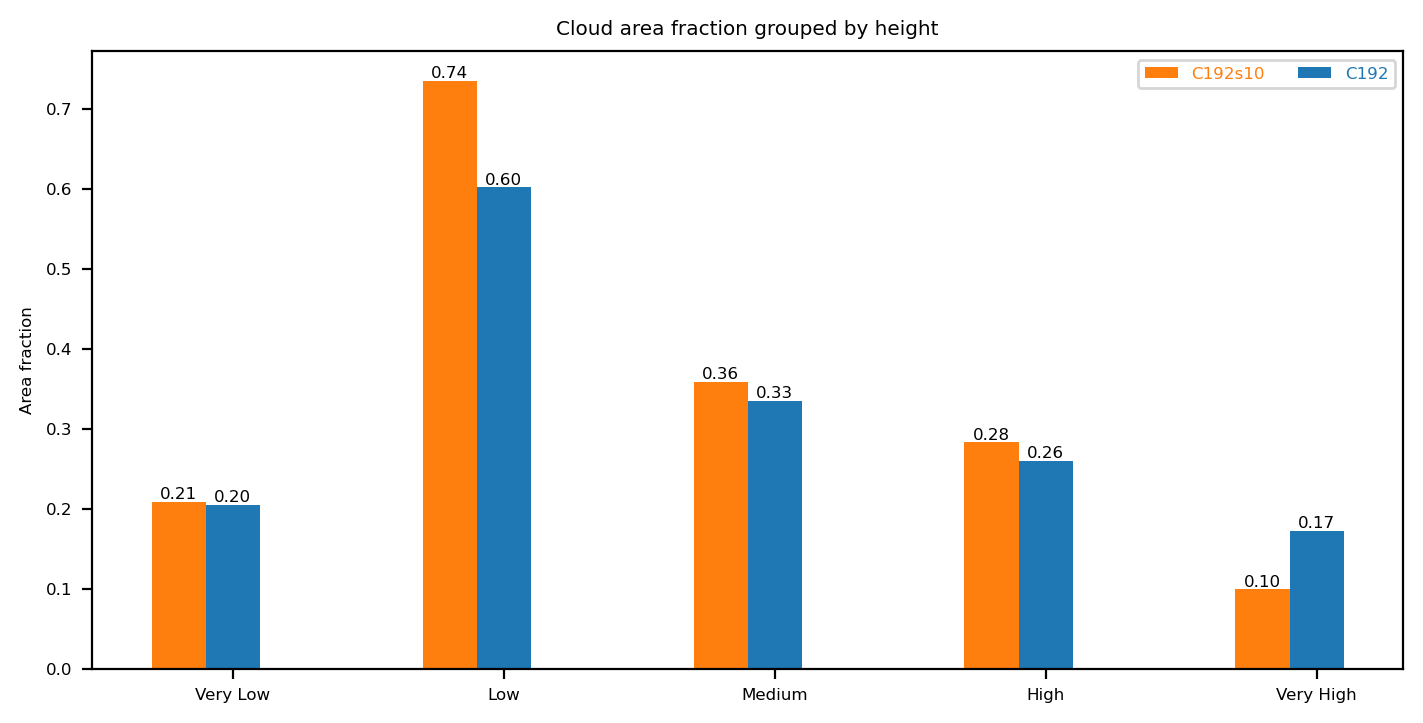

In [8]:
x = np.arange(len(cloud_types))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout="constrained")

for sim_label in show_sim:
    values = [metrics[sim_label][cloud_type] for cloud_type in cloud_types]
    offset = width * multiplier
    rects = ax.bar(
        x + offset,
        values,
        width,
        label=SIMULATIONS[sim_label].title,
        color=SIMULATIONS[sim_label].kw_plt["color"],
    )
    ax.bar_label(rects, fmt="%.2f", padding=0)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Area fraction")
ax.set_title("Cloud area fraction grouped by height")
ax.set_xticks(x + width, [capitalise(s) for s in cloud_types])
ax.legend(loc="upper right", ncols=len(show_sim))
# ax.set_ylim(0, 250)

## 2D maps

In [11]:
Diag = NamedTuple(
    "Diag", [("recipe", callable), ("title", str), ("kw_plt", dict), ("units", str)]
)

In [72]:
DIAGS = {
    "t_sfc": Diag(
        recipe=lambda cl: isel(cl.extract_cube(lfric.t_sfc), lfric.t, -1),
        title="Surface Temperature",
        units="K",
        kw_plt=dict(cmap=cmocean.cm.thermal),
    ),
    "t_sfc_day": Diag(
        recipe=lambda cl: isel(cl.extract_cube(lfric.t_sfc), lfric.t, -1),
        title="Surface Temperature",
        units="K",
        kw_plt=dict(cmap=cmocean.cm.thermal, clim=[250, 295]),
    ),
    "t_sfc_night": Diag(
        recipe=lambda cl: isel(cl.extract_cube(lfric.t_sfc), lfric.t, -1),
        title="Surface Temperature",
        units="K",
        kw_plt=dict(cmap=cmocean.cm.thermal, clim=[170, 220]),
    ),
    "toa_olr": Diag(
        recipe=lambda cl: isel(cl.extract_cube(lfric.toa_olr), lfric.t, -1),
        title="TOA OLR",
        units="$W$ $m^{-2}$",
        kw_plt=dict(cmap=cmocean.cm.gray_r),
    ),
    "caf": Diag(
        recipe=lambda cl: isel(cl.extract_cube(lfric.caf), lfric.t, -1),
        title="Cloud Fraction",
        units="1",
        kw_plt=dict(cmap=swiftascmaps.reputation),
    ),
    "tot_col_w_kinetic_energy": Diag(
        recipe=lambda cl: iris.analysis.maths.apply_ufunc(
            np.log10, isel(cl.extract_cube("tot_col_w_kinetic_energy"), lfric.t, -1)
        ),
        title="Log10 Vertical KE",
        units="$J$ $m^{-2}$",
        kw_plt=dict(cmap=swiftascmaps.red),
    ),
    "mid_in_col": Diag(
        recipe=lambda cl: time_mean(cl.extract_cube("mid_in_col")),
        title="Frequency of midlevel convection",
        units="%",
        kw_plt=dict(cmap=cmocean.tools.crop_by_percent(cmocean.cm.oxy, 20, "min")),
    ),
    "shallow_in_col": Diag(
        recipe=lambda cl: time_mean(cl.extract_cube("shallow_in_col")),
        title="Frequency of shallow convection",
        units="%",
        kw_plt=dict(cmap=cmocean.tools.crop_by_percent(cmocean.cm.oxy, 20, "min")),
    ),
    "caf_h": Diag(
        recipe=lambda cl: isel(cl.extract_cube("high_type_cloud_amount"), lfric.t, -1),
        title="High cloud fraction",
        units="%",
        kw_plt=dict(cmap=swiftascmaps.reputation),
    ),
    "caf_vh": Diag(
        recipe=lambda cl: isel(
            cl.extract_cube("very_high_type_cloud_amount"), lfric.t, -1
        ),
        title="Very high cloud fraction",
        units="%",
        kw_plt=dict(cmap=swiftascmaps.reputation),
    ),
}

In [70]:
# show_sim = ["c192"]
# diag_key = "mid_in_col"
diag_key = "toa_olr"

gv_meshes = {}
stats = {}
for sim_label in show_sim:
    cube2d = DIAGS[diag_key].recipe(dset[sim_label][time_prof])
    cube2d.convert_units(tex2cf_units(DIAGS[diag_key].units))
    gv_meshes[sim_label] = {}
    gv_meshes[sim_label][diag_key] = cube2d_to_mesh(cube2d)
    stats[sim_label] = {}
    stats[sim_label][diag_key] = {}
    stats[sim_label][diag_key]["mean"] = float(
        ugrid_spatial_mean(
            DIAGS[diag_key].recipe(dset[sim_label][time_prof]),
            weights=dset[sim_label]["cell_area"].lazy_data(),
        ).data
    )

/home/ds591/miniforge3/envs/plot3d/lib/python3.12/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'mesh_coordinates', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'mesh_coordinates'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/home/ds591/miniforge3/envs/plot3d/lib/python3.12/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'mesh_coordinates', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'mesh_coordinates'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))


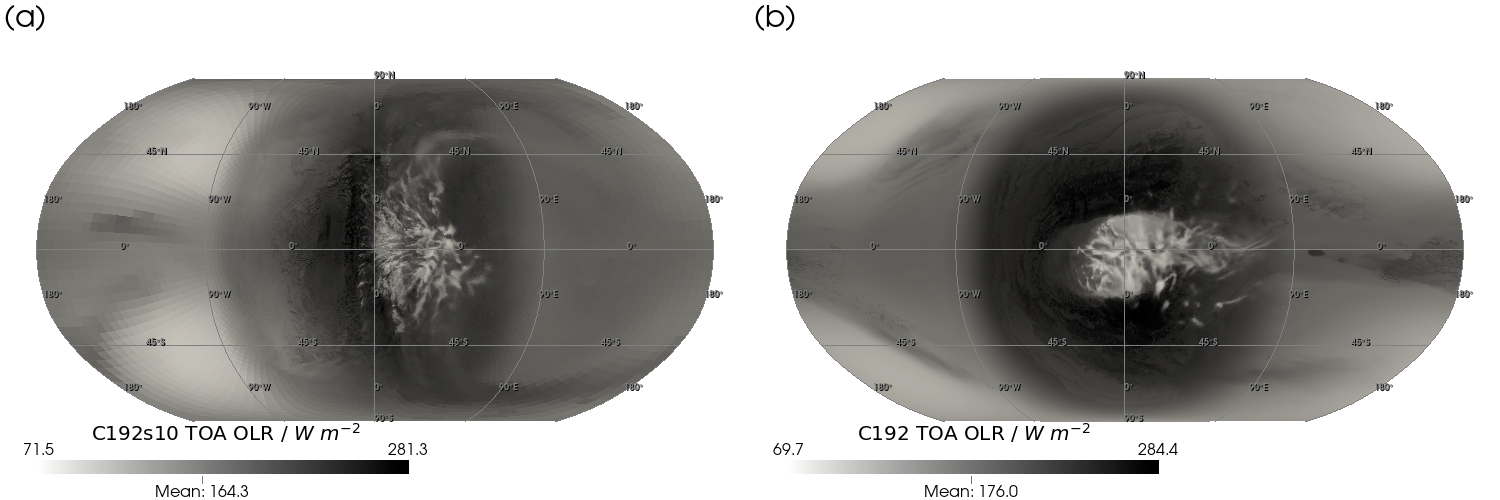

In [73]:
plotter = gv.GeoPlotter(
    window_size=[750 * len(show_sim), 500],
    crs=ccrs.Robinson(),
    shape=(1, (len(show_sim))),
    border=False,
)
zoom = 1.55
kw_grat = dict(
    lon_step=90,
    lat_step=45,
    mesh_args={"color": "grey"},
    point_labels_args={"shape_opacity": 0, "text_color": "grey", "shadow": True},
)
letters = subplot_label_generator()

for sim_idx, sim_label in enumerate(show_sim):
    plotter.subplot(0, sim_idx)
    plotter.add_text(
        f"({next(letters)})",
        position="upper_left",
        font_size=12,
    )
    # plotter.add_text(
    #     f"Mean: {stats[sim_label][diag_key]['mean']:.1f}",
    #     position="lower_right",
    #     font_size=10,
    # )
    plotter.add_mesh(
        gv_meshes[sim_label][diag_key],
        show_scalar_bar=True,
        zlevel=0,
        scalar_bar_args={
            "title": f"{SIMULATIONS[sim_label].title} {DIAGS[diag_key].title} / {DIAGS[diag_key].units}",
            "title_font_size": 20,
            "label_font_size": 16,
            "shadow": False,
            "n_labels": 2,
            "italic": False,
            "fmt": "%.1f",
            "font_family": "arial",
            "width": 0.5,
            "vertical": False,
            "position_x": 0.05,
            "position_y": 0.05,
        },
        **DIAGS[diag_key].kw_plt,
        annotations={
            stats[sim_label][diag_key][
                "mean"
            ]: f"Mean: {stats[sim_label][diag_key]['mean']:.1f}",
        },
    )
    plotter.add_graticule(**kw_grat)
    plotter.view_xy()
    plotter.camera.zoom(zoom)

plotter.show(jupyter_backend="static")

plotter.screenshot(
    paths.figures
    / "drafts"
    / f"nat_mesh__{'_'.join(SIMULATIONS[sim_label].work_name for sim_label in show_sim)}__{time_prof}__{diag_key}"
);